# Image net

In [1]:
from pathlib import Path
import argparse

import torch
from torch import nn
from skimage import io

from emonet.models import EmoNet

import cv2

# torch.backends.cudnn.benchmark =  True

# #Parse arguments
# parser = argparse.ArgumentParser()
# parser.add_argument('--nclasses', type=int, default=8, choices=[5,8], help='Number of emotional classes to test the model on. Please use 5 or 8.')
# parser.add_argument('--image_path', type=str, default="images/example.png", help='Path to a face image.')
# args = parser.parse_args()

# Parameters of the experiments
n_expression = 8
#device = 'cuda:0'
device = 'cpu'
image_size = 256
emotion_classes = {0:"Neutral", 1:"Happy", 2:"Sad", 3:"Surprise", 4:"Fear", 5:"Disgust", 6:"Anger", 7:"Contempt"}
#image_path = Path(__file__).parent / args.image_path
image_path1 = "/Users/zhengyuanrui/dynamic_facial_emo/emonet/data/img/IMG_8004.JPG"
image_path2 = "/Users/zhengyuanrui/dynamic_facial_emo/emonet/data/img/profile.png"
# Loading the model 
state_dict_path = "/Users/zhengyuanrui/face/emonet/pretrained/emonet_8.pth"

print(f'Loading the model from {state_dict_path}.')
state_dict = torch.load(str(state_dict_path), map_location='cpu')
state_dict = {k.replace('module.',''):v for k,v in state_dict.items()}
net = EmoNet(n_expression=n_expression).to(device)
net.load_state_dict(state_dict, strict=False)
net.eval()

print(f'Testing on a single image')
print(f'------------------------')
# Load image in RGB format
image_rgb1 = io.imread(image_path1)[:,:,:3]
image_rgb2 = io.imread(image_path2)[:,:,:3]
# Resize image to (256,256)
image_rgb1 = cv2.resize(image_rgb1, (image_size, image_size))
image_rgb2 = cv2.resize(image_rgb2, (image_size, image_size))
# Load image into a tensor: convert to RGB, and put the tensor in the [0;1] range
image_tensor1 = torch.Tensor(image_rgb1).permute(2,0,1).to(device)/255.0
image_tensor2 = torch.Tensor(image_rgb2).permute(2,0,1).to(device)/255.0

def register_hooks(model, target_layers, img_idx):
    """
    注册钩子以从指定层提取特征，并附带图像索引信息。
    """
    if not isinstance(target_layers, list): 
        target_layers = [target_layers]
    
    features = {}

    def get_hook(name, img_idx):
        def hook(module, input, output):
            features[name] = {
                'output': output.detach(),
                'image_idx': img_idx
            }
        return hook

    # 为指定层注册钩子
    for name, layer in model.named_modules():
        if name in target_layers:
            layer.register_forward_hook(get_hook(name, img_idx))
    
    return features

# 定义图片和索引
# 定义图片和索引
image_tensors = [image_tensor1, image_tensor2]
features_all = {}

# 选择你想要提取特征的层
target_layers = ["conv1", "emo_net_2.0.conv1", "avg_pool_2"]

for idx, img in enumerate(image_tensors):
    print(f'Processing Image {idx}')
    
    # 每张图片单独注册钩子，并传递图片索引
    features = register_hooks(net, target_layers, img_idx=idx)

    with torch.no_grad():
        output = net(img.unsqueeze(0))  # Forward pass

        predicted_emotion_class = torch.argmax(nn.functional.softmax(output["expression"], dim=1)).cpu().item()
        
        # 输出结果
        print(f"Image: {idx}")
        print(f"Predicted Emotion {emotion_classes[predicted_emotion_class]} - valence {output['valence'].clamp(-1.0,1.0).cpu().item():.3f} - arousal {output['arousal'].clamp(-1.0,1.0).cpu().item():.3f}")
        
    # 保存每张图片的特征
    features_all[idx] = features.copy()


Loading the model from /Users/zhengyuanrui/face/emonet/pretrained/emonet_8.pth.
Testing on a single image
------------------------
Processing Image 0
Image: 0
Predicted Emotion Anger - valence -0.377 - arousal 0.419
Processing Image 1
Image: 1
Predicted Emotion Neutral - valence -0.087 - arousal 0.255


In [2]:
import matplotlib.pyplot as plt


def plot_feature(features, layer, idx):
    # 提取特征并计算平均
    features_idx = features[idx]
    feature_layer_idx = features_idx[layer]
    feature = torch.mean(feature_layer_idx['output'], dim=1)  # 对通道进行平均
    first_item = feature.cpu().clone().squeeze()  # 选择特征图的索引，确保在 CPU 上处理

    plt.figure(figsize=(8, 8))  # 设置图像大小

    # 可视化单个特征图
    plt.axis('off')  # 不显示坐标轴
    plt.imshow(first_item.detach().numpy(), cmap='gray')  # 使用 gray cmap 可视化
    
    plt.title(f'Feature Map for Layer: {layer}, Index: {idx}')  # 添加标题
    plt.show()  # 显示图


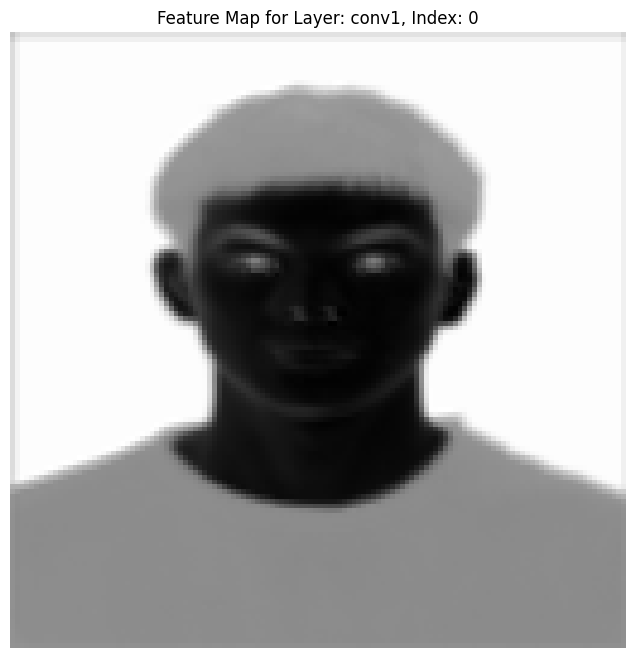

In [3]:
plot_feature(features_all, 'conv1', 0)

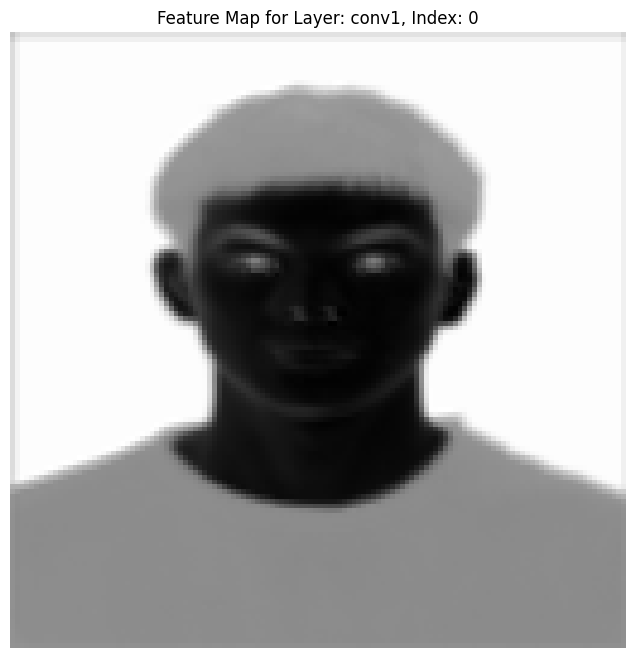

In [4]:
plot_feature(features_all, 'conv1', 0)

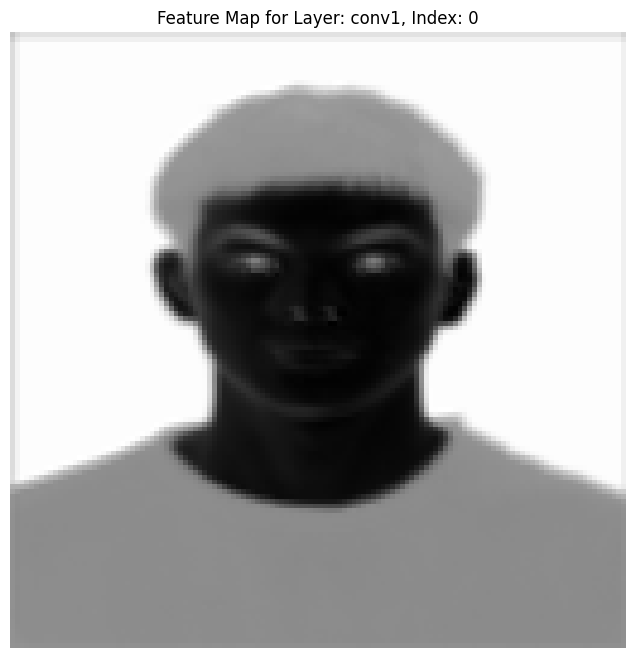

In [5]:
plot_feature(features_all, 'conv1', 0)

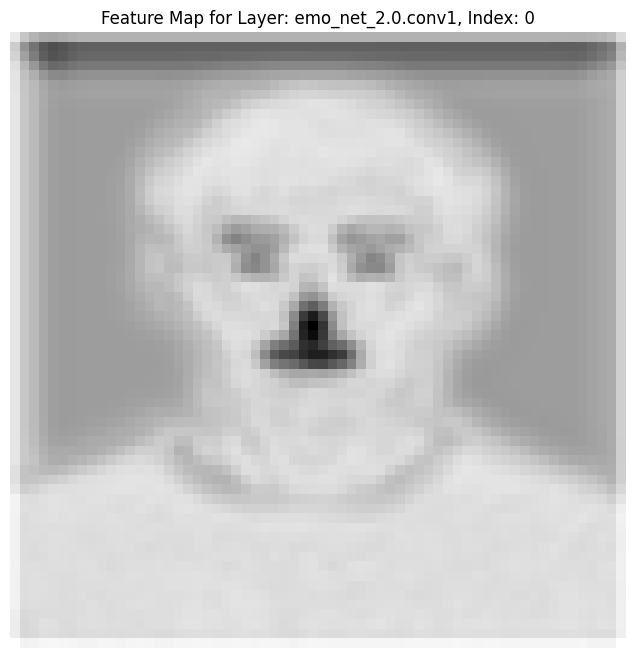

In [6]:
plot_feature(features_all, "emo_net_2.0.conv1", 0)


# Video

In [7]:
from typing import List, Dict
from pathlib import Path
import argparse

import numpy as np
import torch
from torch import nn
from skimage import io
from face_alignment.detection.sfd.sfd_detector import SFDDetector

from emonet.models import EmoNet

import cv2


def load_video(video_path: Path) -> List[np.ndarray]:
    """
    Loads a video using OpenCV.
    """
    video_capture = cv2.VideoCapture(video_path)

    list_frames_rgb = []

    # Reads all the frames
    while video_capture.isOpened():
        ret, frame = video_capture.read()

        if not ret:
            break

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        list_frames_rgb.append(image_rgb)

    return list_frames_rgb


def load_emonet(n_expression: int, device: str):
    """
    Loads the emotion recognition model.
    """

    # Loading the model
    # state_dict_path = Path(__file__).parent.joinpath(
    #     "pretrained", f"emonet_{n_expression}.pth"
    # )
    state_dict_path = "/Users/zhengyuanrui/dynamic_facial_emo/emonet/pretrained/emonet_8.pth"

    print(f"Loading the emonet model from {state_dict_path}.")
    state_dict = torch.load(str(state_dict_path), map_location="cpu")
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    net = EmoNet(n_expression=n_expression).to(device)
    net.load_state_dict(state_dict, strict=False)
    net.eval()

    return net


def run_emonet(
    emonet: torch.nn.Module, frame_rgb: np.ndarray
) -> Dict[str, torch.Tensor]:
    """
    Runs the emotion recognition model on a single frame.
    """
    # Resize image to (256,256)
    image_rgb = cv2.resize(frame_rgb, (image_size, image_size))

    # Load image into a tensor: convert to RGB, and put the tensor in the [0;1] range
    image_tensor = torch.Tensor(image_rgb).permute(2, 0, 1).to(device) / 255.0

    with torch.no_grad():
        output = emonet(image_tensor.unsqueeze(0))

    return output


def plot_valence_arousal(
    valence: float, arousal: float, circumplex_size=512
) -> np.ndarray:
    """
    Assumes valence and arousal in range [-1;1].
    """
    # circumplex_path = Path(__file__).parent / "images/circumplex.png"
    circumplex_path ="/Users/zhengyuanrui/dynamic_facial_emo/emonet/images/circumplex.png"
    circumplex_image = cv2.imread(circumplex_path)
    circumplex_image = cv2.resize(circumplex_image, (circumplex_size, circumplex_size))

    # Position in range [0,circumplex_size/2] - arousal axis goes up, so need to take the opposite
    position = (
        (valence + 1.0) / 2.0 * circumplex_size,
        (1.0 - arousal) / 2.0 * circumplex_size,
    )

    cv2.circle(
        circumplex_image, (int(position[0]), int(position[1])), 16, (0, 0, 255), -1
    )

    return circumplex_image


def make_visualization(
    frame_rgb: np.ndarray,
    face_crop_rgb: np.ndarray,
    face_bbox: torch.Tensor,
    emotion_prediction: Dict[str, torch.Tensor],
    font_scale=2,
) -> np.ndarray:
    """
    Composes the final visualization with detected face, landmarks, discrete and continuous emotions.
    """
    # Visualize the detected face
    cv2.rectangle(
        frame_rgb,
        (face_bbox[0], face_bbox[1]),
        (face_bbox[2], face_bbox[3]),
        (255, 0, 0),
        8,
    )

    # Add the discrete emotion next to it
    predicted_emotion_class_idx = (
        torch.argmax(nn.functional.softmax(emotion_prediction["expression"], dim=1))
        .cpu()
        .item()
    )
    frame_rgb = cv2.putText(
        frame_rgb,
        emotion_classes[predicted_emotion_class_idx],
        ((face_bbox[0] + face_bbox[2]) // 2, face_bbox[1] + 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        (255, 0, 0),
        2,
        cv2.LINE_AA,
    )

    # Landmarks visualization
    # Resize to the original face_crop image size
    heatmap = torch.nn.functional.interpolate(
        emotion_prediction["heatmap"],
        (face_crop_rgb.shape[0], face_crop_rgb.shape[1]),
        mode="bilinear",
    )

    landmark_visualization = face_crop_rgb.copy()
    for landmark_idx in range(heatmap[0].shape[0]):
        # Detect the position of each landmark and draw a circle there
        landmark_position = (
            heatmap[0, landmark_idx, :, :] == torch.max(heatmap[0, landmark_idx, :, :])
        ).nonzero()
        cv2.circle(
            landmark_visualization,
            (
                int(landmark_position[0][1].cpu().item()),
                int(landmark_position[0][0].cpu().item()),
            ),
            4,
            (255, 255, 255),
            -1,
        )

    # Valence and arousal visualization
    circumplex_bgr = plot_valence_arousal(
        emotion_prediction["valence"].clamp(-1.0, 1.0),
        emotion_prediction["arousal"].clamp(-1.0, 1.0),
        frame_rgb.shape[0],
    )

    # Compose the final visualization
    visualization = np.zeros(
        (frame_rgb.shape[0], frame_rgb.shape[1] + frame_rgb.shape[0] // 2, 3),
        dtype=np.uint8,
    )

    # Resize the circumplex and face crop to match the frame size
    circumplex_bgr = cv2.resize(
        circumplex_bgr, (frame_rgb.shape[0] // 2, frame_rgb.shape[0] // 2)
    )
    landmark_visualization = cv2.resize(
        landmark_visualization, (frame_rgb.shape[0] // 2, frame_rgb.shape[0] // 2)
    )
    visualization[:, : frame_rgb.shape[1], :] = frame_rgb[:, :, ::-1].astype(np.uint8)
    visualization[
        : frame_rgb.shape[0] // 2, frame_rgb.shape[1] :, :
    ] = landmark_visualization[:, :, ::-1].astype(
        np.uint8
    )  # OpenCV needs BGR
    visualization[frame_rgb.shape[0] // 2 :, frame_rgb.shape[1] :, :] = (
        circumplex_bgr.astype(np.uint8)
    )

    return visualization

In [8]:
list_frames_rgb = load_video("/Users/zhengyuanrui/Desktop/651_1729083434.mp4")

In [9]:
len(list_frames_rgb)

399

In [10]:
device = "cpu"
image_size = 256
emotion_classes = {
    0: "Neutral",
    1: "Happy",
    2: "Sad",
    3: "Surprise",
    4: "Fear",
    5: "Disgust",
    6: "Anger",
    7: "Contempt",
}

print(f"Loading emonet")
emonet = load_emonet(n_expression, device)

print(f"Loading face detector")
sfd_detector = SFDDetector(device)

print(f"Loading video")
# video_path = Path(__file__).parent / args.video_path
video_path = Path("/Users/zhengyuanrui/Desktop/651_1729083434.mp4")
list_frames_rgb = load_video(video_path)

visualization_frames = []

features_all = [None] * len(list_frames_rgb)  # 初始化一个列表以保存每帧特征


# 选择你想要提取特征的层
target_layers = ["conv1","emo_net_2.0.conv1"]

for i, frame in enumerate(list_frames_rgb):

    # Run face detector
    with torch.no_grad():
        # Face detector requires BGR frame
        detected_faces = sfd_detector.detect_from_image(frame[:, :, ::-1])

    # If at least a face has been detected, run emotion recognition on the first face
    if len(detected_faces)>0:
        # Only take the first detected face
        bbox = np.array(detected_faces[0]).astype(np.int32)

        face_crop = frame[bbox[1] : bbox[3], bbox[0] : bbox[2], :]
        ### important 
        # feauture extract 
        features = register_hooks(emonet, target_layers, img_idx=i)
        
        emotion_prediction = run_emonet(emonet, face_crop.copy())
        features_all[i] = features.copy()  # Use i instead of idx
        visualization_bgr = make_visualization(
            frame.copy(), face_crop.copy(), bbox, emotion_prediction
        )
        visualization_frames.append(visualization_bgr)
    else:
        # Visualization without emotion
        visualization = np.zeros(
            (frame.shape[0], frame.shape[1] + frame.shape[0] // 2, 3),
            dtype=np.uint8,
        )
        visualization[:, : frame.shape[1], :] = frame[:, :, ::-1].astype(np.uint8)
        features_all[i] = None  # Use i instead of idx
        visualization_frames.append(visualization)

    if i % 100 == 0:
        print(f"Ran prediction on {i}/{len(list_frames_rgb)} frames")

# Write the result as a video
if visualization_frames:
    # save_path = Path(__file__).parent / args.output_path
    save_path = Path("/Users/zhengyuanrui/Desktop/output.mp4")

    out = cv2.VideoWriter(
        save_path,
        #-1,
        cv2.VideoWriter_fourcc(*'mp4v'),  # 使用 mp4v 编码器
        24.0,
        (visualization_frames[0].shape[1], visualization_frames[0].shape[0]),
    )

    for frame in visualization_frames:
        out.write(frame)

Loading emonet
Loading the emonet model from /Users/zhengyuanrui/dynamic_facial_emo/emonet/pretrained/emonet_8.pth.
Loading face detector
Loading video
Ran prediction on 0/399 frames
Ran prediction on 100/399 frames
Ran prediction on 200/399 frames
Ran prediction on 300/399 frames


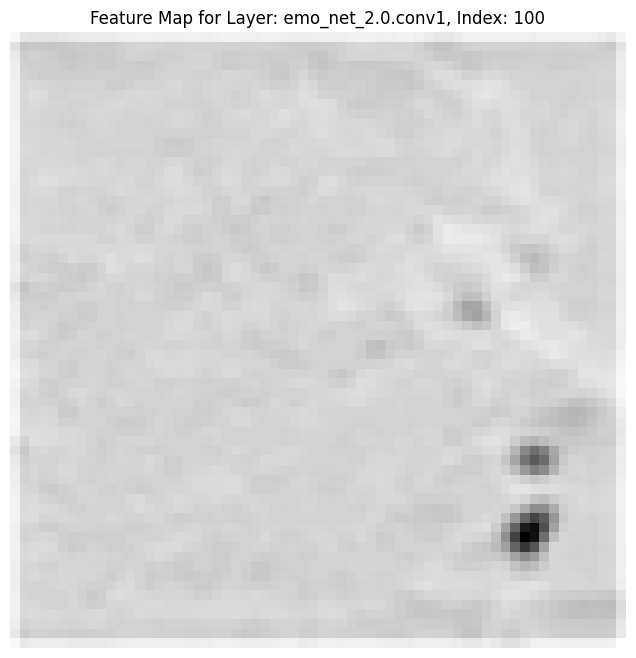

In [11]:
plot_feature(features_all, "emo_net_2.0.conv1", 100)

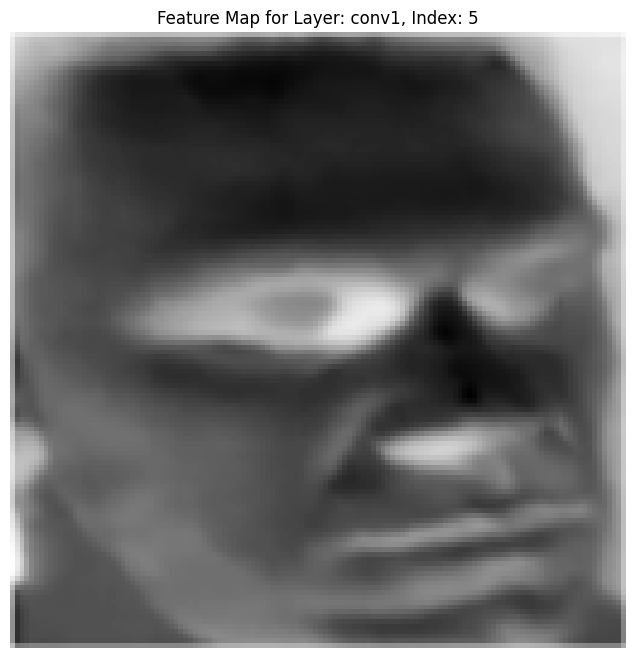

In [12]:
plot_feature(features_all, "conv1", 5)

In [13]:
def save_feature_as_video(features_all, layer, video_output_path, fps=30):
    """
    将特征图保存为视频，并将其转换为灰度图像。
    """
    # 获取第一帧的特征图形状，确保视频写入器尺寸正确
    first_valid_feature = None
    for feature_dict in features_all:
        if feature_dict is not None and feature_dict.get(layer) is not None:
            first_valid_feature = feature_dict[layer]['output']
            break

    if first_valid_feature is None:
        raise ValueError(f"No valid features found for layer {layer}.")
    
    # 计算第一帧的特征图均值，确保它是二维的
    feature_mean = torch.mean(first_valid_feature, dim=1).cpu().squeeze().detach().numpy()
    height, width = feature_mean.shape

    # 设置视频编写器
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 使用 mp4 编码
    video_writer = cv2.VideoWriter(video_output_path, fourcc, fps, (width, height), isColor=False)

    for frame_idx, feature_dict in enumerate(features_all):
        if feature_dict is None or feature_dict.get(layer) is None:
            print(f"Frame {frame_idx} has no valid features. Writing an empty frame.")
            # 写入空白帧
            frame = np.zeros((height, width), dtype=np.uint8)
        else:
            # 获取特征图并计算平均
            feature = feature_dict[layer]['output']
            feature_mean = torch.mean(feature, dim=1).cpu().squeeze().detach().numpy()

            # 防止极差为 0，导致全黑帧
            if np.ptp(feature_mean) == 0:
                frame = np.zeros((height, width), dtype=np.uint8)  # 全黑帧
            else:
                # 转换为 8 位灰度图像，以便 cv2 处理
                frame = (255 * (feature_mean - np.min(feature_mean)) / np.ptp(feature_mean)).astype(np.uint8)

        # 写入当前帧到视频
        video_writer.write(frame)

        if frame_idx % 100 == 0:
            print(f"Writing frame {frame_idx}/{len(features_all)}")

    # 释放视频写入器
    video_writer.release()
    print(f"Video saved to {video_output_path}")

# 假设 features_all 是一个列表，包含了每一帧的特征数据
save_feature_as_video(features_all, 'conv1', 'feature_map_output.mp4', fps=30)
save_feature_as_video(features_all, 'emo_net_2.0.conv1', 'feature_map_output_emoconv1.mp4', fps=30)


Writing frame 0/399
Writing frame 100/399
Writing frame 200/399
Writing frame 300/399
Video saved to feature_map_output.mp4
Writing frame 0/399
Writing frame 100/399
Writing frame 200/399
Writing frame 300/399
Video saved to feature_map_output_emoconv1.mp4


In [14]:
def compute_average_feature(features_all, target_layers):
    """
    对每一层在整个视频上的特征进行求平均
    """
    # 初始化字典，用于存储累加的特征
    avg_features = {layer: None for layer in target_layers}
    frame_count = len(features_all)
    
    # 遍历每一帧
    for frame_idx, feature_dict in enumerate(features_all):
        if feature_dict is None:
            print(f"Frame {frame_idx} has no valid features. Skipping this frame.")
            continue  # 跳过没有特征的帧
        
        for layer in target_layers:
            if feature_dict.get(layer) is None:
                print(f"Layer {layer} has no features in frame {frame_idx}. Skipping.")
                continue
            
            feature = feature_dict[layer]['output']
            feature_mean = torch.mean(feature, dim=1)  # 计算每一帧的特征图均值
            
            # 累加特征图
            if avg_features[layer] is None:
                avg_features[layer] = feature_mean
            else:
                avg_features[layer] += feature_mean
    
    # 计算每一层的平均特征
    for layer in target_layers:
        if avg_features[layer] is not None:
            print(frame_count)
            avg_features[layer] /= frame_count  # 求平均
    
    return avg_features

# 假设 features_all 是包含特征的列表
target_layers = ['conv1', 'emo_net_2.0.conv1']  # 你感兴趣的层
avg_features = compute_average_feature(features_all, target_layers)

# 打印结果
for layer, feature in avg_features.items():
    if feature is not None:
        print(f"Average feature map for layer {layer}: {feature.shape}")


399
399
Average feature map for layer conv1: torch.Size([1, 128, 128])
Average feature map for layer emo_net_2.0.conv1: torch.Size([1, 64, 64])


In [15]:
def concat_and_mean_features(features_all, layer):
    """
    across frames
    对所有帧的特征图进行拼接，然后求平均。
    
    features_all: 包含每帧特征图的列表
    layer: 指定要处理的层
    """
    # 创建一个列表来存储每一帧的特征
    feature_list = []
    
    # 遍历每一帧的特征并将其添加到列表
    for features in features_all:
        if layer in features and features[layer] is not None:
            # 提取指定层的特征
            feature = features[layer]['output']
            feature_list.append(feature)

    if len(feature_list) == 0:
        raise ValueError("No valid features found for the specified layer.")

    # 将所有特征图在指定维度上拼接 (这里在 batch 维度拼接，即 dim=0)
    concatenated_features = torch.cat(feature_list, dim=0)
    # 对拼接后的特征图进行求均值 (这里对 batch 维度求均值，即 dim=0)
    mean_features = torch.mean(concatenated_features, dim=0)

    return mean_features

# 调用函数来计算平均特征图
mean_feature_map = concat_and_mean_features(features_all, 'conv1')
mean_feature_map.shape

torch.Size([64, 128, 128])